# Home Credit Default Risk

*Can you predict how capable each applicant is of repaying a loan?*

Spencer Brothers, Radhika Bhakta, Amber Cash, Tami Salvador


## Table of Contents

1. [Introduction](#intro)
2. [Models Considered](#models-considered)
3. [Modeling Process](#model-process)
4. [Model Performance](#model-performance)
4. [Results](#results)

## Introduction

Most lending services are based on credit, which excludes a large demographic of people (those with no credit history) from buying a home. Taking an uninformed lending approach is an unsustainable business practice that may leave underserved populations worse off, so using smart lending practices is essential to both Home Credit’s longevity and financial equity for unbanked populations.

### Benefit of a Solution

By better modeling clients’ behaviors, Home Credit can successfully predict clients’ repayment abilities. This supports Home Credit’s goals in two key areas:

1.	Home Credit will decrease costs of clients defaulting on loans or making late payments, supporting Home Credit's sustainability in an ever-changing economic and political ecosystem.

2.	Clients capable of repayment will receive necessary resources that empower their financial success when other financial institutions fail to lend. Loans will be given with principal, maturity, and a repayment schedule that optimizes clients’ lending experience


### Performance Benchmarks

Because the data is highly imbalanced, with only 8.07% of observations belonging to the positive target class (`TARGET = 1`), a simple majority classifier would classify all applicants as not defaulting, having an accuracy of 91.97%, precision of 0, recall of 0, and thus an F-1 score of 0. We will try to exceed all of these in our model.

We will also try to maximize the area under the Reciever Operating Characteristic Curve (Kaggle score) for our model. Because a random classifier would have a Kaggle score of 50%, we will try to exceed this value as well.

### Setup

Import libraries and read in data

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score

In [2]:
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, make_scorer, precision_recall_curve


In [ ]:
# mount to drive to access data
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# read raw data into pandas dataframes
data_folder = '/content/drive/MyDrive/MSBA_Practice_Project/data'

app_train = pd.read_csv(f'{data_folder}/application_train.csv')
app_test = pd.read_csv(f'{data_folder}/application_test.csv')

### Feature Engineering

Along with `application_{train|test}.csv`, Home Credit also includes transactional datasets with information about each applicant. For this project, we will use `previous_application.csv` to hopefully improve our model performance. Because there are potentially multiple records for each applicant in `previous_application.csv`, we will make the following aggregations before joining the transactional data with `application_[train|test}.csv`:

1. Proportion of Past Loans Refused (PROP_NAME_PREV_REFUSED)
    - A high proportion of past loan refusals may indicate financial instability or a history of risky borrowing behavior, suggesting a higher likelihood of default.
3. Average Time Since Loan Decision (AVG_DAYS_DECISION)
	- The recency of past credit decisions can provide insight into financial behavior. Frequent recent loan applications may indicate financial distress or an increased reliance on borrowing.
4. Average Previous Credit Amount (AVG_PREV_CREDIT)
	- The typical size of previous loans can serve as an indicator of financial habits. Larger past loans may suggest significant debt obligations, which could impact the ability to repay future loans.
5. Average Down Payment (AVG_DOWN_PAYMENT)
	- Consistently low down payments may suggest over-leveraging, increasing the risk of default by indicating a lack of financial reserves.
6. Average Repayment Discrepancy (AVG_PREV_REPAYMENT_DISC)
	- The difference between the expected and actual last due date for previous loans can highlight repayment behavior. Large discrepancies may indicate late payments or loan extensions, both of which are potential risk factors.
7. Average Rate of Down Payment (AVG_RATE_DOWN_PAYMENT)
	- A lower down payment rate may suggest that borrowers are stretching their finances to secure a loan, which could indicate higher financial risk.
8. Count of Previous Loans (CNT_PREV_LOANS)
	- The total number of previous loans provides insight into borrowing patterns. A high number of past loans could indicate experience in managing debt but may also suggest a dependency on credit, which could be a risk factor.

In [ ]:
# read transactional data into dataframe
prev_app = pd.read_csv(f'{data_folder}/previous_application.csv')

# Create a new column for the difference between DAYS_LAST_DUE and DAYS_LAST_DUE_1ST_VERSION
prev_app["PREV_REPAYMENT_DISC"] = prev_app["DAYS_LAST_DUE"] - prev_app["DAYS_LAST_DUE_1ST_VERSION"]

# Aggregate previous applications
prev_agg = prev_app.groupby("SK_ID_CURR").agg(
    # Proportion of past loans refused
    PROP_NAME_PREV_REFUSED=("NAME_CONTRACT_STATUS", lambda x: (x == "Refused").mean()),

    # Average time since loan decision (recent approvals may indicate cash flow issues)
    AVG_DAYS_DECISION=("DAYS_DECISION", "mean"),

    # Average previous credit amount (larger past loans might indicate risky borrowing behavior)
    AVG_PREV_CREDIT=("AMT_CREDIT", "mean"),

    # Average down payment (low down payments suggest high leverage, possible risk)
    AVG_DOWN_PAYMENT=("AMT_DOWN_PAYMENT", "mean"),

    # Average difference between actual and expected last due date (delayed repayment = risk)
    AVG_PREV_REPAYMENT_DISC=("PREV_REPAYMENT_DISC", "mean"),

    # Average rate of down payment (low rates could indicate over-leveraging)
    AVG_RATE_DOWN_PAYMENT=("RATE_DOWN_PAYMENT", "mean"),

    # Count of previous loans (a high number of past loans might indicate dependency on credit)
    CNT_PREV_LOANS=("SK_ID_PREV", "count")
).reset_index()

# Merge aggregated previous applications with application_train
train_merged = app_train.merge(prev_agg, on="SK_ID_CURR", how="left")

### Handling Missing Data and Outliers

Many columns in the main dataset are mostly comprised of missing data, and most rows are missing data. By using binning and simple median imputation, we can fill all the missing data. While we may lose some detail in our data with binning, it offers a more accurate view of many highly predictive columns that may have structural missingness or where missing data represents a difference in populations, like in EXT_SOURCE{1|2|3}.

#### Missing Categorical Data

We used an LLM (Chat GPT 4o) to analyze the data dictionary, `HomeCredit_columns_description.csv`, and return a list of categorical features. We use this list to handle missing values in categorical columns, as well as encoding them as integers for model building and evaluation.

While many categoriacal variables are nominal, we will use label encoding (assume all categorical variables are ordinal) to prevent excess dimensionality on an already large dataset.

In [ ]:
categorical_columns = [
    'TARGET', 'NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
    'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'ORGANIZATION_TYPE',
    'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE',
    'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'FONDKAPREMONT_MODE',
    'HOUSETYPE_MODE', 'TOTALAREA_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE', 'OWN_CAR_AGE', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG','YEARS_BUILD_AVG','COMMONAREA_AVG','ELEVATORS_AVG',
    'ENTRANCES_AVG','FLOORSMIN_AVG','LANDAREA_AVG','LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI',
    'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMIN_MEDI',  'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI', 'FLAG_DOCUMENT_2',
    'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12',
    'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21', 'REG_REGION_NOT_LIVE_REGION',
    'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'WEEKDAY_APPR_PROCESS_START', 'CODE_GENDER'
]

numeric_columns = [col for col in train_merged.columns.values if col not in categorical_columns]
numeric_columns.remove('SK_ID_CURR')
print(len(numeric_columns) + len(categorical_columns)) # sanity check: should be 128 = app_cols + agg_cols - 1 (ID_col)

for col in tqdm(categorical_columns):
  train_merged[col] = train_merged[col].astype(str).fillna('missing')


128


100%|██████████| 94/94 [00:13<00:00,  7.04it/s]


#### Missing Numeric Data / Outliers

Because this notebook is focusing on tree-based modeling algorithms, we will use binning to handle missing data. This also handles outliers, since bins are based on quantiles. If there is an outlier in any feature, it will just be grouped in with the highest quantile.

In [ ]:
# Bin numerical columns using quantiles
max_bins = 50
for col in tqdm(numeric_columns):
  train_merged[col] = pd.qcut(train_merged[col], q=max_bins,labels=False, duplicates='drop').astype(str)


100%|██████████| 34/34 [00:05<00:00,  5.96it/s]


In [ ]:
# fill missing values with 'missing'
train_merged.replace('nan','missing',inplace=True)

In [ ]:
train_merged

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,PROP_NAME_PREV_REFUSED,AVG_DAYS_DECISION,AVG_PREV_CREDIT,AVG_DOWN_PAYMENT,AVG_PREV_REPAYMENT_DISC,AVG_RATE_DOWN_PAYMENT,CNT_PREV_LOANS
0,100002,1,Cash loans,M,N,Y,0,16,18,24.0,...,0.0,0.0,0.0,missing,missing,missing,missing,missing,missing,missing
1,100003,0,Cash loans,F,N,N,0,19,43,38.0,...,0.0,0.0,0.0,missing,missing,missing,missing,missing,missing,missing
2,100004,0,Revolving loans,M,Y,Y,0,1,1,0.0,...,0.0,0.0,0.0,missing,missing,missing,missing,missing,missing,missing
3,100006,0,Cash loans,F,N,Y,0,10,14,31.0,...,missing,missing,missing,0.0,45.0,44.0,missing,1.0,missing,0.0
4,100007,0,Cash loans,M,N,Y,0,8,22,19.0,...,0.0,0.0,0.0,0.0,20.0,35.0,missing,15.0,missing,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,12,8,29.0,...,missing,missing,missing,0.0,41.0,8.0,0.0,15.0,0.0,0.0
307507,456252,0,Cash loans,F,N,Y,0,2,10,6.0,...,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing
307508,456253,0,Cash loans,F,N,Y,0,12,30,32.0,...,0.0,0.0,0.0,0.0,5.0,4.0,7.0,18.0,15.0,0.0
307509,456254,1,Cash loans,F,N,Y,0,14,17,17.0,...,0.0,0.0,0.0,0.0,41.0,36.0,0.0,26.0,0.0,0.0


## Models Considered

### Naive Bayes Classifier

#### Drop high-missing columns
`
df = df.dropna(thresh=len(df) * 0.6, axis=1)
`

#### Fill missing values
`
for col in df.columns:
    if df[col].dtype == 'object':
        df[col].fillna(df[col].mode()[0], inplace=True)  
    else:
        df[col].fillna(df[col].median(), inplace=True)  
`

#### Encode categorical features
`
df = pd.get_dummies(df, drop_first=True)  # One-hot encoding
`

#### Define features and target
`
X = df.drop(columns=['TARGET'])
y = df['TARGET']
`

#### Normalize features using MinMaxScaler
`
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
`

#### Handle class imbalance using SMOTE
`
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)
`

#### Split into training and testing sets
`
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
`

#### Train Naïve Bayes model
`
nb_classifier = GaussianNB()
nb_classifier.fit(X_train, y_train)
`

#### Predict and evaluate
`
y_pred = nb_classifier.predict(X_test)
`

This code performs a series of steps to preprocess a dataset and train a Naive Bayes classifier. It starts by loading the dataset and dropping columns with more than 40% missing values. It then fills missing values for categorical columns using the mode (most frequent value) and for numerical columns using the median. The categorical features are one-hot encoded, converting them into binary columns to make them suitable for machine learning models. The features are normalized using Min-Max scaling to bring all numerical variables into a consistent range between 0 and 1. To address class imbalance, the code applies SMOTE (Synthetic Minority Over-sampling Technique) to create synthetic samples for the minority class, ensuring the dataset has a more balanced distribution. The data is split into training and testing sets, with 80% used for training and 20% for testing. A Gaussian Naive Bayes classifier is trained on the resampled data, and predictions are made on the test set. The model's performance is evaluated through accuracy, a classification report (which includes precision, recall, F1-score, and support for each class), and a confusion matrix, providing a detailed assessment of the model's ability to correctly classify the target variable.

The Naive Bayes model achieved an accuracy of 54%. The classification report shows high recall (94%) for defaulters (Class 1), meaning the model is effective at identifying those who default on loans. However, it struggles to correctly classify non-defaulters (Class 0), with only 14% recall, leading to a large number of false positives (48,653 cases). This shows great imbalance within this model. This is also reflected in the confusion matrix, where the model misclassifies most non-defaulters as defaulters while correctly predicting most actual defaulters. The likely causes include class imbalance, feature correlations, and the Naïve Bayes assumption of feature independence, which may not hold for financial data. To improve performance.



### Decision Tree

Next, we considered a decision tree. We created a decision tree in RStudio to make predictions by recursively splitting data into subsets based on feature values. Each internal node represents a decision, each branch represents an outcome of the test, and each leaf node represents a final prediction or classification.

Here is the code used:

```{r}
# Load necessary libraries
library(caret)       # For data splitting
library(rpart)       # For decision tree model
library(rpart.plot)  # For visualizing the decision tree
library(pROC)        # For AUC-ROC calculation

# Set seed for reproducibility
set.seed(42)

# Step 1: Split the train_data into 80-20 for training and validation
# Perform the 80-20 split
split_indices <- createDataPartition(train_data$TARGET, p = 0.8, list = FALSE)

# Create training and validation sets
train_split <- train_data[split_indices, ]  # 80% for training
valid_split <- train_data[-split_indices, ]  # 20% for validation

# Check split dimensions
cat("Training Data Dimensions:", dim(train_split), "\n")
cat("Validation Data Dimensions:", dim(valid_split), "\n")

# Step 2: Train the Decision Tree model on the training split
tree_model <- rpart(
  TARGET ~ .,
  data = train_split,
  method = "class",
  cp = 0.001,  # Lower complexity parameter to allow more splits
  parms = list(prior = c(0.3, 0.7)),  # Handle class imbalance with adjusted weights
  control = rpart.control(maxdepth = 10)  # Allow deeper splits for more granularity
)

# Step 3: Visualize the Decision Tree
rpart.plot(
  tree_model,
  type = 2,
  extra = 102,  # Display probabilities and counts for each node
  under = TRUE,
  faclen = 0,
  cex = 0.8
)

# Step 4: Evaluate the model on the validation split
# Make probability predictions for the validation set
valid_pred_prob <- predict(tree_model, newdata = valid_split, type = "prob")[, 2]  # Probability for class "1"

# Convert probabilities to binary class predictions
valid_pred_class <- ifelse(valid_pred_prob > 0.5, 1, 0)

# Step 5: Calculate AUC-ROC for the validation set
valid_auc <- roc(valid_split$TARGET, valid_pred_prob)
cat("Validation AUC:", auc(valid_auc), "\n")
```

The train data was split 70% train and 30% test. The training data dimensions were: 246009, while the validation data dimensions were 61502. For instance, the first split occurs when EXT_SOURCE_3 >= 0.47. There are some limitations of doing a decision tree in R. In this case, we used the rpart.plot library instead of the C50 library. When using C50, we couldn't get it to work although trying multiple times. rpart.plot creates a decision tree that is not as easy to understand or as readable as C50. Overall, the validation AUC was 0.65, but we realized that other models did better.



### Logistic Regression

The last model approach was using logistic regression to predict loan default risk, leveraging various financial indicators such as income, credit amount, annuities, and previous loan history. The dataset was preprocessed by aggregating features from the bureau.csv and previous_application.csv files. The aggregated features were then merged with the main dataset to enrich the available predictors. Missing values were imputed using the median, and features were standardized for better model performance. The data was split into training and validation sets, ensuring stratification to handle class imbalance.



```
# Merge aggregated features with training data
train_data = train_data.merge(bureau_agg, on='SK_ID_CURR', how='left')
train_data = train_data.merge(previous_app_agg, on='SK_ID_CURR', how='left')

# Select features and target
features = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'DAYS_BIRTH',
            'AMT_CREDIT_SUM_SUM', 'AMT_CREDIT_SUM_MEAN', 'AMT_CREDIT_SUM_DEBT_SUM', 'AMT_CREDIT_SUM_DEBT_MEAN',
            'AMT_APPLICATION_MEAN', 'AMT_APPLICATION_MAX', 'AMT_CREDIT_MEAN', 'AMT_CREDIT_MAX']
target = 'TARGET'

X = train_data[features]
y = train_data[target]

# Handle missing values (simple imputation)
X.fillna(X.mean(), inplace=True)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
```
The baseline model was a majority class classifier, which predicted the most frequent class (loan repaid) and achieved an accuracy of approximately 91% due to class imbalance. The logistic regression model was trained using 5-fold cross-validation, and the AUC score was used as a key performance metric. The initial logistic regression model achieved a Kaggle score of approximately 0.67–0.70, indicating moderate predictive power.
```
# Baseline model: Majority class classifier (predicts the most frequent class)
majority_class = y_train.mode()[0]
y_majority_pred = np.full_like(y_val, majority_class)
majority_accuracy = accuracy_score(y_val, y_majority_pred)
print(f'Majority Class Accuracy: {majority_accuracy:.4f}')

# Perform k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Fit logistic regression model with cross-validation
model = LogisticRegression()
cross_val_auc = cross_val_score(model, X_train_scaled, y_train, cv=kf, scoring='roc_auc')
print(f'Cross-Validation AUC: {cross_val_auc.mean():.4f}')

# Train logistic regression model on full training set
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_val_scaled)
y_prob = model.predict_proba(X_val_scaled)[:, 1]

# Evaluate model
accuracy = accuracy_score(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_prob)

print(f'Validation Accuracy: {accuracy:.4f}')
print(f'Validation Kaggle score Score: {roc_auc:.4f}')
```

To improve model performance, an interaction term (INCOME_CREDIT_RATIO) was introduced, capturing the relationship between income and credit amount. This slightly improved the AUC score, but precision and recall did not increase significantly, suggesting that logistic regression might be too simplistic for this problem.

```
# Fit logistic regression models with interaction terms
X_train['INCOME_CREDIT_RATIO'] = X_train['AMT_INCOME_TOTAL'] / X_train['AMT_CREDIT']
X_val['INCOME_CREDIT_RATIO'] = X_val['AMT_INCOME_TOTAL'] / X_val['AMT_CREDIT']

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

model_interaction = LogisticRegression()
model_interaction.fit(X_train_scaled, y_train)

# Make predictions
y_pred_interaction = model_interaction.predict(X_val_scaled)
y_prob_interaction = model_interaction.predict_proba(X_val_scaled)[:, 1]

# Evaluate interaction model
accuracy_interaction = accuracy_score(y_val, y_pred_interaction)
roc_auc_interaction = roc_auc_score(y_val, y_prob_interaction)

print(f'Validation Accuracy with Interaction: {accuracy_interaction:.4f}')
print(f'Validation Kaggle score Score with Interaction: {roc_auc_interaction:.4f}')
```
The data showed that features such as income, credit amount, and previous loan behavior had predictive value, but class imbalance remained a challenge so we moved onto other approaches.

### Final Model Selection

We used a XGBoost as our final model because it outperformed all of our benchmarks in 5-fold cross validation.


### Decision Tree

Next, we considered a decision tree. We created a decision tree in RStudio to make predictions by recursively splitting data into subsets based on feature values. Each internal node represents a decision, each branch represents an outcome of the test, and each leaf node represents a final prediction or classification.

Here is the code used:

In [ ]:
# Set seed for reproducibility
np.random.seed(42)

# Step 1: Split the data into 70-30 for training and validation
train_split, valid_split = train_test_split(train_merged, test_size=0.3, stratify=train_merged['TARGET'], random_state=42)

# Check split dimensions
print("Training Data Dimensions:", train_split.shape)
print("Validation Data Dimensions:", valid_split.shape)

# Step 2: Train the Decision Tree model on the training split
tree_model = DecisionTreeClassifier(
    criterion='gini',  # Equivalent to method = "class" in rpart
    max_depth=10,  # Allow deeper splits for more granularity
    min_samples_split=2,  # Default value
    min_samples_leaf=1,  # Default value
    class_weight={0: 0.3, 1: 0.7},  # Handle class imbalance
    random_state=42
)

tree_model.fit(train_split.drop(columns=['TARGET']), train_split['TARGET'])

# Step 3: Visualize the Decision Tree
plt.figure(figsize=(12, 8))
plot_tree(tree_model, feature_names=train_split.columns.drop('TARGET'), class_names=['0', '1'], filled=True)
plt.show()

# Step 4: Evaluate the model on the validation split
valid_pred_prob = tree_model.predict_proba(valid_split.drop(columns=['TARGET']))[:, 1]  # Probability for class "1"
valid_pred_class = (valid_pred_prob > 0.5).astype(int)

# Step 5: Calculate AUC-ROC for the validation set
valid_auc = roc_auc_score(valid_split['TARGET'], valid_pred_prob)
print("Validation AUC:", valid_auc)


The train data was split 70% train and 30% test. The training data dimensions were: 246009, while the validation data dimensions were 61502. For instance, the first split occurs when EXT_SOURCE_3 >= 0.47. There are some limitations of doing a decision tree in R. In this case, we used the rpart.plot library instead of the C50 library. When using C50, we couldn't get it to work although trying multiple times. rpart.plot creates a decision tree that is not as easy to understand or as readable as C50. Overall, the validation AUC was 0.65, but we realized that other models did better.

## Models Considered

### Naive Bayes

In [ ]:
# encode categorical features
nb_df = pd.get_dummies(train_merged, drop_first=True)

# define features and target
nb_X = nb_df.drop(columns=['TARGET'])
nb_y = nb_df['TARGET']

# normalize features
scaler = MinMaxScaler()
nb_X_scaled = scaler.fit_transform(nb_X)

# handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
nb_X_resampled, nb_y_resampled = smote.fit_resample(nb_X_scaled, nb_y)

# split into testing and training sets
nb_X_train, nb_X_test, nb_y_train, nb_y_test = train_test_split(nb_X_resampled, nb_y_resampled, test_size=0.2, random_state=42)

# train naive bayes model
nb_classifier = GaussianNB()
nb_classifier.fit(nb_X_train, nb_y_train)

# Predict probabilities for ROC AUC
y_pred_proba = nb_classifier.predict_proba(X_test)[:, 1]

# Calculate AUC score
auc_score = roc_auc_score(y_test, y_pred_proba)

print(f"AUC Score: {auc_score:.4f}")


### Logistic Regression

The last model approach was using logistic regression to predict loan default risk, leveraging various financial indicators such as income, credit amount, annuities, and previous loan history. The dataset was preprocessed by aggregating features from the bureau.csv and previous_application.csv files. The aggregated features were then merged with the main dataset to enrich the available predictors. Missing values were imputed using the median, and features were standardized for better model performance. The data was split into training and validation sets, ensuring stratification to handle class imbalance.

In [ ]:
# Features and target for modeling
features = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'DAYS_BIRTH']
target = 'TARGET'

X = train_merged[features]
y = train_merged[target]

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

The baseline model was a majority class classifier, which predicted the most frequent class (loan repaid) and achieved an accuracy of approximately 91% due to class imbalance. The logistic regression model was trained using 5-fold cross-validation, and the Kaggle score was used as a key performance metric. The initial logistic regression model achieved a Kaggle score of approximately 0.67–0.70, indicating moderate predictive power.

In [ ]:
# Baseline model: Majority class classifier (predicts the most frequent class)
majority_class = train_merged['TARGET'].mode()[0]
y_majority_pred = np.full_like(y_val, majority_class)
majority_accuracy = accuracy_score(y_val, y_majority_pred)
print(f'Majority Class Accuracy: {majority_accuracy:.4f}')

# Perform k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

X_train_2 = X_train.replace('missing', 0)
X_val_2 = X_val.replace('missing', 0)

# Fit logistic regression model with cross-validation
model = LogisticRegression()
cross_val_auc = cross_val_score(model, X_train_2, y_train, cv=kf, scoring='roc_auc')
print(f'Cross-Validation AUC: {cross_val_auc.mean():.4f}')

# Train logistic regression model on full training set
model.fit(X_train_2, y_train)

# Make predictions
y_pred = model.predict(X_val_2)
y_prob = model.predict_proba(X_val_2)[:, 1]

# Evaluate model
accuracy = accuracy_score(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_prob)

print(f'Validation Accuracy: {accuracy:.4f}')
print(f'Validation Kaggle Score: {roc_auc:.4f}')

Majority Class Accuracy: 0.9193
Cross-Validation AUC: 0.6166
Validation Accuracy: 0.9192
Validation Kaggle Score: 0.6145


To improve model performance, an interaction term (INCOME_CREDIT_RATIO) was introduced, capturing the relationship between income and credit amount. This slightly improved the AUC score, but precision and recall did not increase significantly, suggesting that logistic regression might be too simplistic for this problem.

In [ ]:
# Fit logistic regression models with interaction terms
X_train_2['AMT_INCOME_TOTAL'] = pd.to_numeric(X_train_2['AMT_INCOME_TOTAL'], errors='coerce')
X_train_2['AMT_CREDIT'] = pd.to_numeric(X_train_2['AMT_CREDIT'], errors='coerce')

X_val_2['AMT_INCOME_TOTAL'] = pd.to_numeric(X_val_2['AMT_INCOME_TOTAL'], errors='coerce')
X_val_2['AMT_CREDIT'] = pd.to_numeric(X_val_2['AMT_CREDIT'], errors='coerce')

X_train_2['INCOME_CREDIT_RATIO'] = X_train_2['AMT_INCOME_TOTAL'] / X_train_2['AMT_CREDIT']
X_val_2['INCOME_CREDIT_RATIO'] = X_val_2['AMT_INCOME_TOTAL'] / X_val_2['AMT_CREDIT']

X_train_2.replace([np.inf, -np.inf], np.nan, inplace=True)
X_val_2.replace([np.inf, -np.inf], np.nan, inplace=True)

X_train_2.fillna(0, inplace=True)
X_val_2.fillna(0, inplace=True)

model_interaction = LogisticRegression()
model_interaction.fit(X_train_2, y_train)

# Make predictions
y_pred_interaction = model_interaction.predict(X_val_2)
y_prob_interaction = model_interaction.predict_proba(X_val_2)[:, 1]

# Evaluate interaction model
accuracy_interaction = accuracy_score(y_val, y_pred_interaction)
roc_auc_interaction = roc_auc_score(y_val, y_prob_interaction)

print(f'Validation Accuracy with Interaction: {accuracy_interaction:.4f}')
print(f'Validation Kaggle score Score with Interaction: {roc_auc_interaction:.4f}')

Validation Accuracy with Interaction: 0.9192
Validation Kaggle score Score with Interaction: 0.6144


The data showed that features such as income, credit amount, and previous loan behavior had predictive value, but class imbalance remained a challenge so we moved onto other approaches.

### Upsampling Data

We tried oversampling the positive target class, but this reduced model performance in nearly every metric except the recall of our model.

## Modeling Process

We essentially de-linearized the data by binning because this notebook will focus on tree-based models. Specifically, we will train a XGBoost model, a gradient boosting algorithm. We tried implementing other gradient boosting algorithms, like CatBoost, but they took far to long to train. XGBoost is optimal for our use because it can be trained in parallel on the GPU, which significantly reduces execution times for hyperparameter tuning.

Hyperparameters will be selected using a randomized search with 3-fold cross validation using the area under the ROC curve.

The best model parameters will then be used to train a final XG Boost model, which we will evaluate in the next section.

***NOTE*** : if using google colab, be careful about running this section, and make sure to use the A100 GPU Runtime.

In [ ]:
# Load & Preprocess Data For XGBoost Specifically
X = train_merged.drop(columns=['TARGET', 'SK_ID_CURR'])  # Drop ID and target
y = train_merged['TARGET'].astype(int)  # Extract target

# Convert all categorical features to numerical values using Label Encoding
label_encoders = {}
for col in X.columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le  # Save encoders for later use if needed

In [ ]:
# Define XGBoost Model
xgb_model = xgb.XGBClassifier(
    tree_method='hist',
    device='cuda', # Enable GPU acceleration
    n_jobs=-1
)

# Define Hyperparameter Grid for RandomizedSearchCV
param_dist = {
    'n_estimators': [500, 1000],
    'learning_rate': [0.01, 0.1],
    'max_depth': [4, 6, 8],
    'reg_lambda': [1, 3, 5],  # L2 regularization
    'subsample': [0.7, 1.0],  # Fraction of data to use per tree
    'colsample_bytree': [0.7, 1.0]  # Fraction of features per tree
}

# Set Up RandomizedSearchCV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    cv=cv,
    scoring='roc_auc',
    n_iter=30,  # Randomly test 30 parameter sets
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# Train with RandomizedSearchCV
random_search.fit(X, y)

# Output Best Hyperparameters
print("Best parameters:", random_search.best_params_)
print("Best Kaggle score:", random_search.best_score_)


Fitting 5 folds for each of 30 candidates, totalling 150 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters: {'subsample': 1.0, 'reg_lambda': 5, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
Best Kaggle score: 0.7572801680275808


The above code block took about 15 minutes to run, which isn't too bad considering we trained 150 ensemble models.

## Model Performance

In [ ]:
def evaluate_model(model, X, y, threshold=0.5, cv_splits=5):
    # Perform Stratified K-Fold Cross-Validation
    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=42)

    # Get predicted probabilities for TARGET=1
    y_pred_proba = cross_val_predict(model, X, y, cv=cv, method="predict_proba")[:, 1]

    # Apply custom threshold
    y_pred = (y_pred_proba >= threshold).astype(int)

    # Compute evaluation metrics
    avg_scores = {
        'Accuracy': accuracy_score(y, y_pred),
        'Precision': precision_score(y, y_pred, pos_label=1, zero_division=0),
        'Recall': recall_score(y, y_pred, pos_label=1),
        'F1': f1_score(y, y_pred, pos_label=1),
        'Kaggle score': roc_auc_score(y, y_pred_proba)  # Kaggle score remains unchanged
    }

    # Print evaluation results
    print("\nModel Evaluation with 5-Fold Cross-Validation (Threshold = {:.2f}):".format(threshold))
    for metric, score in avg_scores.items():
        print(f"Mean {metric}: {score:.4f}")

    return avg_scores

In [ ]:
# Extract the best trained model
best_model = random_search.best_estimator_

avg_scores_def_threshold = evaluate_model(best_model, X, y, threshold=0.5, cv_splits=5)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:44:08] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)



Model Evaluation with 5-Fold Cross-Validation (Threshold = 0.50):
Mean Accuracy: 0.9196
Mean Precision: 0.5394
Mean Recall: 0.0254
Mean F1: 0.0485
Mean Kaggle score: 0.7573


### Optimizing the Decision Threshold

The evaluation above uses a decision threshold of 0.5, which has drawbacks. With a recall of about 2.8%, our model tends to approve bad loans, which increases risk of Home Credit incurring costs due to lendees defaulting. By lowering our decision threshold, our model will will have a higher recall but lower precision. Low precision in our model would represent rejecting good borrowers, decreasing Home Credit's revenue.

We'd like to balance both precision and recall to ensure our model minimizes risk while still approving enough loans, so our decision threshold should maximise our model's F-1 score. This will come at the cost of lowering accuracy, but since the data is already so imbalanced with respect to the target class, accuracy isn't the best metric for evaluating model performance.

In [ ]:
# Get model probabilities for TARGET=1
y_pred_probs = best_model.predict_proba(X)[:, 1]

# Compute precision-recall curve
precisions, recalls, thresholds = precision_recall_curve(y, y_pred_probs)

# Find the threshold that maximizes F1-score
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
best_F1_threshold = thresholds[f1_scores.argmax()]

print(f"Optimal Decision Threshold: {best_F1_threshold:.4f}")

Optimal Decision Threshold: 0.1576


In [ ]:
avg_scores_best_threshold = evaluate_model(best_model, X, y, threshold=best_F1_threshold)


Model Evaluation with 5-Fold Cross-Validation (Threshold = 0.16):
Mean Accuracy: 0.8550
Mean Precision: 0.2491
Mean Recall: 0.3954
Mean F1: 0.3056
Mean Kaggle score: 0.7573


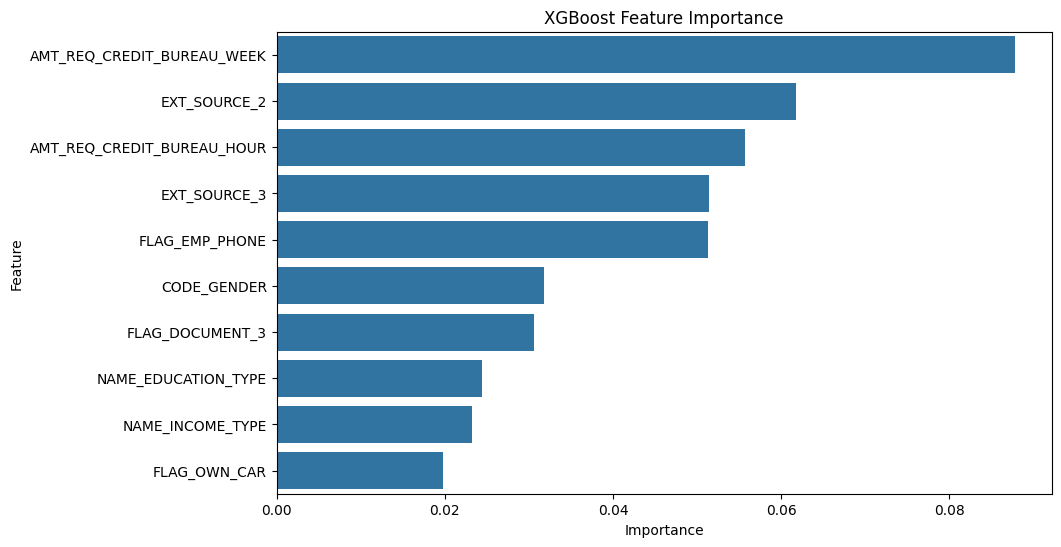

In [ ]:
# prompt: plot the feature importance of best_model

import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'best_model' is your trained XGBoost model
# and 'X' contains your feature data

# Get feature importances
feature_importances = best_model.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df[0:10])
plt.title('XGBoost Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


## Results

Overall, Our final model performed decently. With a mean Kaggle score of 76.16% in cross validation, our model performs much better than a random classifier or simple majority classifier, but there's still room for improvement.

If we were evaluating our model based solely on accuracy, we would use a decision threshold of 0.5 because it exceeded every benchmark set at the beginning of this document. However, as discusses previously, this may introduce unnecessary risks of lending to bad applicants.

Using a lower decision threshold  better balances the risks of lending while still extending credit to trustworthy applicants, at the cost of model accuracy.

## Team Contributions

Spencer performed the XG Boost/gradient boosting analysis and formatted those sections of the notebook. Radhika performed the Naïve Bayes analysis, Amber performed the logistic regression analysis and Tami built the decision tree. The team worked together to format and integrate individual notebooks into one.